# Week 7: Non-context-free languages

In [1]:
from tock import *

## Tuesday

Today we're going to talk about how to show that languages are not context-free. There are two canonical examples of non-context-free languages:

\begin{align*}
B &= \{ \mathtt{a}^n \mathtt{b}^n \mathtt{c}^n \mid n \geq 0 \} \\
D &= \{ ww \mid w \in \{ \mathtt{0}, \mathtt{1} \}^\ast \}.
\end{align*}

<p class="alert alert-info"><b>Read</b> Section 2.3.</p>

### Another pumping lemma

The pumping lemma for context-free languages is a little more complicated than the pumping lemma for regular languages (even though it actually predates it). 

The basic difference is that the pumping now causes _two_ pieces of the string to be repeated instead of just one. Also, whereas in the regular pumping lemma, the repeated piece had to be near the beginning of the string, in the context-free pumping lemma, the two pieces have to be near each other, but can occur anywhere in the string. Other than that, writing proofs using the context-free pumping lemma is the same as using the regular pumping lemma.

As with the regular pumping lemma, we'll start by presenting the argument as a dialogue between Alice and Bill. But some of Alice's reasoning will be unexplained at first.

### As a dialogue

Alice. The language $B=\{\mathtt{a}^n\mathtt{b}^n\mathtt{c}^n\}$ is not context-free.

Bill. Yes it is.

Alice. Do you have a context-free grammar that generates it?

Bill. Yes:

In [5]:
g = grammars.Grammar.from_lines([
    'A -> a A',
    'A -> a B',
    'B -> b C',
    'C -> B c',
    'C -> c'
])
g

Alice. How many nonterminal symbols does your grammar have?

Bill. Let me count..

In [7]:
v = len(g.nonterminals)
v

3

Alice. What's the maximum length of any right-hand side?

Bill. Let me see...

In [8]:
b = max(len(rhs) for lhs, rhs in g.rules)
b

2

Alice. Does your grammar generate this string?

In [16]:
p = max(b**v+1, b**(v+1)) # you don't have to understand this yet
s = ['a']*(p//3+1) + ['b']*(p//3+1) + ['c']*(p//3+1)
' '.join(s)

'a a a a a a b b b b b b c c c c c c'

Bill. Let me see...

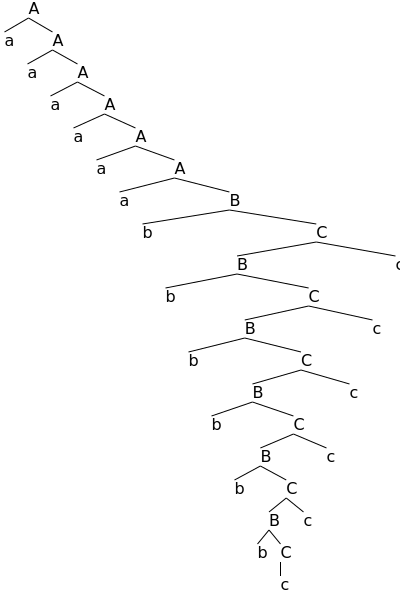

In [18]:
t = grammars.any_parse(g, s)
t

Alice. How long is the longest path in the parse tree?

Bill. Let me see...

In [25]:
def longest_path(node):
    if len(node.children) == 0:
        return [node]
    else:
        return max(([node]+longest_path(child) for child in node.children), key=len)
path = longest_path(t)
labels = [node.label for node in path]
' '.join(labels)

'A A A A A A B C B C B C B C B C B C c'

Alice. In this path, you use the same nonterminal twice, right?

Bill. Let me see...

In [28]:
index = {}
for i in reversed(range(len(path))):
    if labels[i] in index:
        n1 = path[i]
        n2 = index[labels[i]]
        break
    index[labels[i]] = path[i]
else:
    assert False
print("Yes.")

Yes.


Alice. Starting from the bottom of the tree, let $n_1$ be the first occurrence of the first repeated nonterminal. And let $n_2$ be the second occurrence of that nonterminal.

Bill. Okay.

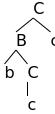

In [30]:
n1

In [31]:
n2

Alice. Let $u$, $v$, $x$, $y$, and $z$ be such that $s = uvxyz$ and $vxy$ is the string under $n_2$ and $x$ is the string under $n_1$.

Bill. Okay.

In [38]:
def leaves(node, foot=None):
    if node == foot:
        return [foot]
    elif len(node.children) == 0:
        return [node.label]
    else:
        result = []
        for child in node.children:
            result.extend(leaves(child, foot))
        return result
def outside(node, foot):
    l = leaves(node, foot)
    i = l.index(foot)
    return l[:i], l[i+1:]

u, z = outside(t, n1)
v, y = outside(n1, n2)
x = leaves(n2)

print('u =', ' '.join(u))
print('v =', ' '.join(v))
print('x =', ' '.join(x))
print('y =', ' '.join(y))
print('z =', ' '.join(z))

u = a a a a a a b b b b b
v = b
x = c
y = c
z = c c c c


Alice. Does your grammar generate this string?

In [45]:
s1 = u + v + v + x + y + y + z
' '.join(s1)

'a a a a a a b b b b b b b c c c c c c c'

Bill. Let me see...

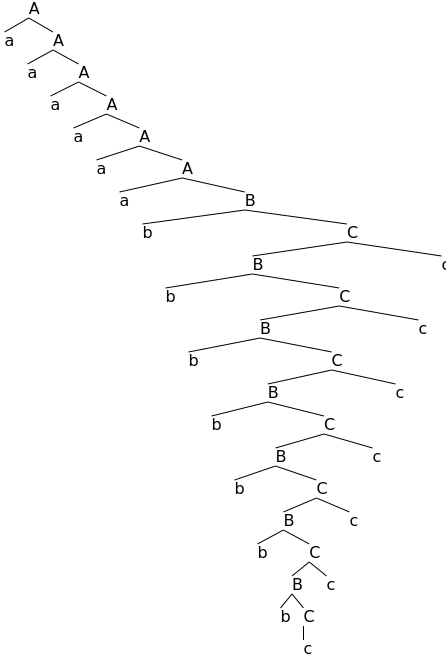

Yes, I lose.


In [46]:
try:
    t1 = grammars.any_parse(g, s1)
except ValueError:
    print("No, I win (this shouldn't happen).")
else:
    display(t1)
    print("Yes, I lose.")

### The pumping length

At this point you should read page 126-127 if you haven't already. But I'd like to explain the choice of the pumping length $p$ in a bit more detail.

Recall that in the regular pumping lemma, the pumping length $p$ was just the number of states in the DFA. Thus $p$ symbols was enough to ensure that the DFA went through a loop, and the loop had to occur within the first $p$ symbols. Now, we want to know how many terminals is long enough to ensure that the CFG has a path with a loop.

Let $b$ be the maximum number of symbols in a right hand side of the grammar, which is also the maximum number of children a node can have. Define the *height* of a tree to be the number of *edges* (equivalently, the number of *nonterminals*) in its longest root-to-leaf path. For example, this tree has height 2:

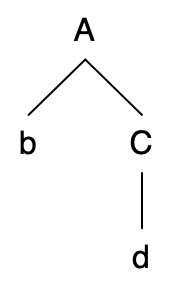

A tree with height 0 has just 1 leaf; a tree with height 1 has at most $b$ leaves; a tree with height 2 has at most $b^2$ leaves, and in general, the largest possible tree with height $h$ has $b^h$ leaves.

We want to set $p$ to guarantee that the tree has a path with a repeated nonterminal, so let's reason backwards to find $p$. There will be a repeated nonterminal if a path has $|V|+1$ nonterminals, that is, the tree has height at least $|V|+1$. The largest tree with height $|V|$ has at most $b^{|V|}$ leaves, so we just need to set $p$ to something bigger than $p=b^{|V|}$. So (reasoning forwards again) if we make the tree have at least $b^{|V|}+1$ leaves, it must have height at least $|V|+1$, that is, it has at least $|V|+1$ nonterminals and a terminal, so by the pigeonhole principle, there must be a repeated nonterminal on this path.

We can say more. If we choose the lowest pair of repeated nonterminals, we know that they both must occur within a subtree of height at most $|V|+1$, which means this subtree must have at most $b^{|V|+1}$ leaves.

To simplify the statement of the lemma, let's set $p$ to the maximum of $b^{|V|}+1$ and $b^{|V|+1}$. (It will always be the latter, except for the edge case $b=1$.) Then we can make the following claim: if the tree has at least $p$ leaves, there must be a path with a repeated nonterminal, and the repeated nonterminal must occur within a subtree with at most $p$ leaves.

### Statement of the lemma

Here's the formal statement of the lemma. It has the same structure as the regular pumping lemma, but with more variables.

- For any context-free language $A$,
- there exists a $p$ (the pumping length), such that
- for any string $s$ such that $|s| \geq p$,
- there exist $u,v,x,y,z$ such that $s=uvxyz$, $|vy|>0$, $|vxy|\leq p$, and
- for all $i$, $uv^ixy^iz \in A$.

### An example proof

Now let's use the pumping lemma to properly prove the non-context-freeness of language $B$.

Suppose that $B$ is context-free. Given $p$ (the pumping length), let $s = \mathtt{a}^n \mathtt{b}^n \mathtt{c}^n$, where $n = \lceil p/3 \rceil$. If $s = uvxyz$ such that either $v$ or $y$ is nonempty, the pumping lemma for context-free languages says that $s' = uvvxyyz \in B$. But this is impossible, for:

- If both $v$ and $y$ contain only one type of symbol, e.g., $v$ contains all $\mathtt{a}$'s and $y$ contains all $\mathtt{b}$'s, then $s'$ cannot have an equal number of all three types of symbol. 

- On the other hand, if either $v$ or $y$ contains two different types of symbol, e.g., contains at least one $\mathtt{a}$ and one $\mathtt{b}$, then $s'$ must have, somewhere, $\mathtt{a}$ after $\mathtt{b}$ or $\mathtt{b}$ after $\mathtt{c}$.

In either case, $s'$ cannot belong to $B$, which is a contradiction.

**Question.** Show that $\{ \mathtt{a}^m \mathtt{b}^n \mathtt{c}^m \mathtt{d}^n \mid m \geq 0, n \geq 0 \}$ is not context-free.

**Question.** Show that $D = \{ ww \mid w \in \{ \mathtt{0}, \mathtt{1} \}^\ast \}$ is not context-free.

**Question.** Show that $C = \{\mathtt{a}^i \mathtt{b}^j \mathtt{c}^k \mid 0 \leq i \leq j \leq k\}$ is not context-free.

## Thursday

### Closure properties

As with proofs of non-regularity, we can often use closure properties to simplify proofs of non-context-freeness or even make proofs possible that would not be possible otherwise. Here's a partial table of closure properties:

| Operation | Regular | Context-free |
|:----------|:--------|:-------------|
| union     | yes     | yes          |
| concatenation | yes | yes          |
| Kleene star | yes   | yes          |
| complementation | yes | **no**     |
| intersection | yes  | **no**       |
| intersection with regular | yes | yes |
| string homomorphism | yes | yes |

The proof of closure under a string homomorphism $\phi$ is very similar to the proof for NFAs, but applied to PDAs: essentially, every transition that reads input $a$ is replaced with zero or more transitions that read $\phi(a)$ (like in Figure 2.23).

The proof of closure under intersection with a regular language is very similar to the intersection construction for DFAs, but applied to a PDA and a DFA. The details are not necessary for you to learn, but here's the construction:
\begin{align*}
P &= (Q_P, \Sigma, \Gamma, \delta_P, s_P, F_P) \\
M &= (Q_M, \Sigma, \delta_M, s_M, F_M) \\
P \cap M &= (Q_P \cap Q_M, \Sigma, \Gamma, \delta, (s_P, s_M), F_P \times F_M) \\
\delta((q, r), a, x) &= ((q', \delta_M(r, a)), x') && \text{if $\delta_P(q, a, x) = (q', x')$} \\
\delta((q, r), \varepsilon, x) &= ((q', r), x') && \text{if $\delta_P(q, \varepsilon, x) = (q', x')$}
\end{align*}

Here's an example of where closure properties are useful: Prove that 
\begin{equation}
E = \{\texttt{a}^n \texttt{b}^n \texttt{c}^n \mid \text{$n$ even}\} \cup \{\texttt{a}^i \texttt{b}^j \texttt{c}^k \mid \text{$i$ odd} \}
\end{equation}
is not context-free.

If you try to use the pumping lemma directly on this language, you'll run into trouble with the case where $vxy$ is all $\texttt{a}$'s. You can form a string $s' = uv^lxy^lz$, but if $s'$ has an odd number of $\texttt{a}$'s, then you won't be able to show that $s'$ doesn't belong to $E$.

Instead, suppose that $E$ is context-free. Then $E \cap (\texttt{aa})^\ast \texttt{b}^\ast \texttt{c}^\ast$ must also be context-free (because CFLs are closed under intersection with regular languages). But $E \cap (\texttt{aa})^\ast \texttt{b}^\ast \texttt{c}^\ast = \{\texttt{a}^n \texttt{b}^n  \texttt{c}^n \mid \text{$n$ even}\}$, and this language is easy to prove non-context-free, since it's so similar to $B$ above.

### Are human languages context-free? (Optional)